In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import image

from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential, Model

from keras.layers import Activation, Flatten, Dense,BatchNormalization, Dropout
from keras.applications.inception_resnet_v2  import InceptionResNetV2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from matplotlib.pyplot import imshow
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications  import InceptionV3
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2
import shutil
import glob
import os
from PIL import Image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import MobileNetV3Small
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19

from keras.applications import InceptionResNetV2


In [45]:
#Train
train_glioma = 'C:/Users/Admin/Downloads/thesis/dataset/Training/glioma'
train_menignioma = 'C:/Users/Admin/Downloads/thesis/dataset/Training/meningioma'
train_pituitary = 'C:/Users/Admin/Downloads/thesis/dataset/Training/pituitary'
train_no = 'C:/Users/Admin/Downloads/thesis/dataset/Training/notumor'
train_dir = 'C:/Users/Admin/Downloads/thesis/dataset/Training/'

#Test
test_glioma = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/glioma_tumor'
test_menignioma = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/meningioma_tumor'
test_pituitary = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/pituitary_tumor'
test_no = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/no_tumor'
test_dir = 'C:/Users/Admin/Downloads/thesis/dataset/valid data/'


In [46]:
#for training dataset
list_brain_image=[train_glioma, train_menignioma, train_no, train_pituitary]
classes=['glioma', 'menignioma','No_tumor','pituitary']
images_location=[]
labels=[]


for i,j in zip(list_brain_image, classes):
    list_of_file=os.listdir(i)
    for f in list_of_file:
        image_location=os.path.join (i,f)
        images_location.append(image_location)
        labels.append(j)



print ('Number of image train: ', len(images_location), '   Number of image train has label: ', len(labels))


#for test dataset
list_brain_image_test=[ test_glioma, test_menignioma, test_no, test_pituitary]
classes_test=['glioma', 'menignioma','No_tumor','pituitary']
images_location_test=[]
labels_test=[]


for i,j in zip(list_brain_image_test, classes_test):
    list_of_file_test=os.listdir(i)
    for f in list_of_file_test:
        image_location_test=os.path.join (i,f)
        images_location_test.append(image_location_test)
        labels_test.append(j)



print ('Number of image test: ', len(images_location_test), '   Number of image test has label: ', len(labels_test))

Number of image train:  7023    Number of image train has label:  7023
Number of image test:  3160    Number of image test has label:  3160


In [47]:
#for training data
Location =pd.Series(images_location, name='location')
Label=pd.Series(labels, name='labels')
#connect the path of brain image and their label 
connect_image_label=pd.concat([Location,Label], axis=1)
connect_image_label = pd.DataFrame(connect_image_label, columns=['location', 'labels'])
connect_image_label.head()

#for test data
Location_test =pd.Series(images_location_test, name='location')
Label_test=pd.Series(labels_test, name='labels')
connect_image_label_test=pd.concat([Location_test,Label_test], axis=1)
connect_image_label_test = pd.DataFrame(connect_image_label_test, columns=['location', 'labels'])
connect_image_label_test.head()

,location,labels
0,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
1,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
2,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
3,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma
4,C:/Users/Admin/Downloads/thesis/dataset/valid ...,glioma


In [48]:
#split the data to 3 part : train dataset, test dataset, validation data
train,valid = train_test_split(connect_image_label, train_size=0.8, random_state=3)

print(f"train set: {train.shape}")
print(f"validation set: {valid.shape}")

train set: (5618, 2)
validation set: (1405, 2)


In [49]:
#rescale image from rgb (0-255) to (0,1)
train_image_datagen = ImageDataGenerator(rescale = 1./255.)
test_image_datagen = ImageDataGenerator(rescale = 1.0/255.)
valid_image_datagen = ImageDataGenerator(rescale = 1.0/255.)



train_datagen = train_image_datagen.flow_from_dataframe(train,
                                              x_col = 'location', y_col ='labels',
                                              target_size = (299,299),
                                              class_mode = 'categorical', shuffle = True)


validation_datagen = valid_image_datagen.flow_from_dataframe(valid,
                                            target_size=(299,299), x_col = 'location', y_col ='labels',
                                            class_mode='categorical',
                                            batch_size= 20, shuffle=True)
                                            

test_datagen = test_image_datagen.flow_from_dataframe(connect_image_label_test,
                                            target_size = (299,299), x_col = 'location', y_col ='labels',
                                             class_mode = 'categorical',
                                            batch_size = 15, shuffle = False)

Found 5618 validated image filenames belonging to 4 classes.
Found 1405 validated image filenames belonging to 4 classes.
Found 3160 validated image filenames belonging to 4 classes.


In [50]:
#for inceptionV3 model

from keras.layers import concatenate, Input, Flatten, Dense
from keras.models import Model
from keras.applications import ResNet50, VGG19
from keras.optimizers import RMSprop
from keras.applications  import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

from keras.applications import MobileNetV3Small

# Define the input shape
input_shape = (299, 299, 3)

# Create one input for both x1 and x2
input_layer = Input(shape=input_shape)

# Create base models
base_model_1 = InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)


# Freeze the layers of the base models
for layer in base_model_1.layers:
    layer.trainable = False

# Add your own custom layers on top of the base models
x1 = base_model_1.output
x1 = Flatten()(x1)
x1 = Dense(256, activation='relu')(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)
output = Dense(4, activation='softmax')(x1)
inceptionV3 = Model(inputs=input_layer, outputs=output)
# Display the model summary
inceptionV3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d_376 (Conv2D)         (None, 149, 149, 32)         864       ['input_5[0][0]']             
                                                                                                  
 batch_normalization_379 (B  (None, 149, 149, 32)         96        ['conv2d_376[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_376 (Activation  (None, 149, 149, 32)         0         ['batch_normalization_37

In [51]:
inceptionV3.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.001),  metrics= ['categorical_accuracy'])

history = inceptionV3.fit(train_datagen, validation_data = validation_datagen, epochs = 30)

Epoch 1/30
176/176 [==============================] - 144s 807ms/step - loss: 0.5094 - categorical_accuracy: 0.8298 - val_loss: 0.2565 - val_categorical_accuracy: 0.9160
Epoch 2/30
176/176 [==============================] - 137s 777ms/step - loss: 0.2140 - categorical_accuracy: 0.9233 - val_loss: 0.2071 - val_categorical_accuracy: 0.9295
Epoch 3/30
176/176 [==============================] - 138s 784ms/step - loss: 0.1382 - categorical_accuracy: 0.9551 - val_loss: 0.1570 - val_categorical_accuracy: 0.9480
Epoch 4/30
176/176 [==============================] - 138s 784ms/step - loss: 0.1066 - categorical_accuracy: 0.9642 - val_loss: 0.1430 - val_categorical_accuracy: 0.9480
Epoch 5/30
176/176 [==============================] - 138s 786ms/step - loss: 0.0739 - categorical_accuracy: 0.9761 - val_loss: 0.1308 - val_categorical_accuracy: 0.9537
Epoch 6/30
176/176 [==============================] - 139s 792ms/step - loss: 0.0577 - categorical_accuracy: 0.9836 - val_loss: 0.1261 - val_categoric

In [52]:
model_inceptionV3_final = inceptionV3  # Get model (Sequential, Functional Model, or Model subclass)
model_inceptionV3_final.save('inceptionV3_23_1.keras')  # The file needs to end with the .keras extension

In [53]:
model_inceptionV3_final = keras.models.load_model('inceptionV3_23_1.keras')
# Evaluate the model on the test data`
test_loss, test_accuracy = model_inceptionV3_final.evaluate(test_datagen)

211/211 [==============================] - 59s 276ms/step - loss: 0.3077 - categorical_accuracy: 0.9297


In [54]:
np.save('incetionV3_history_23_1.npy',history.history)

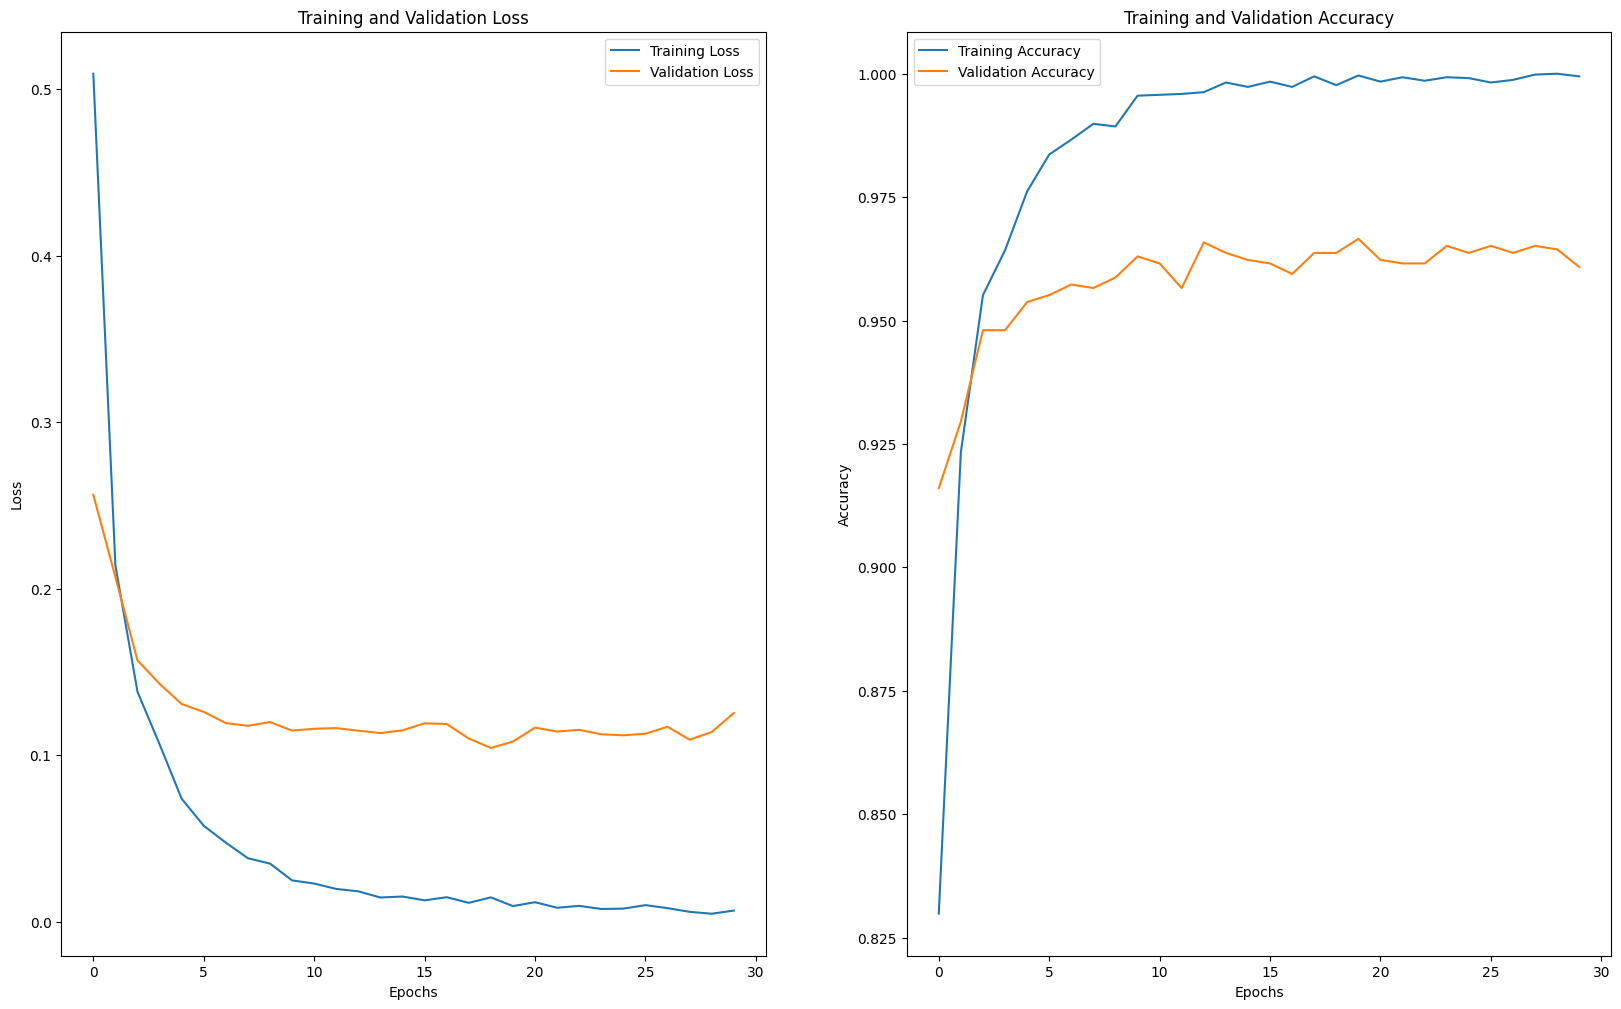

In [55]:
import matplotlib.pyplot as plt
import numpy as np

# Load the history dictionary from the file
history = np.load('incetionV3_history_23_1.npy', allow_pickle=True).item()

# Plot loss and accuracy curves
plt.figure(figsize=(20, 12))
# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history['val_categorical_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
